## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| apply_filter.py | lena_gray.png 파일에 필터를 적용합니다. |  |  |
| gradient_check.py | SimpleCovNet이 기울기를 올바로 계산하는지 확인합니다. |  |  |
| params.pkl | 미리 학습된 가중치 값들입니다. |  |  |
| simple_convnet.py | “Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax” 순으로 흐르는 단순한 합성곱 신경망(CNN)입니다. | 7.5 CNN 구현하기 | 251 |
| train_convnet.py | SimpleConvNet으로 MNIST 데이터셋을 학습합니다. | 7.5 CNN 구현하기 | 254 |
| visualize_filter.py | 합성곱 1번째 층의 가중치를 학습 전과 후로 나눠 시각화해봅니다. 이미 학습된 가중치 값(params.pkl)을 읽어서 사용하므로 학습 과정은 생략됩니다. | 7.6.1 1번째 층의 가중치 시각화하기 | 254 |

# simple_convnet.py

In [7]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# train_convnet.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

In [ ]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

train loss:2.3004019847865367
=== epoch:1, train acc:0.209, test acc:0.206 ===
train loss:2.297608101698613
train loss:2.2931956002171034
train loss:2.286766898545858
train loss:2.274504458979153
train loss:2.269881151900904
train loss:2.244082377057742
train loss:2.2269853763760334
train loss:2.1943206493658445
train loss:2.2044455615203473
train loss:2.178715493412201
train loss:2.1430846960981023
train loss:2.101173415668006
train loss:2.044079889290397
train loss:1.9865180559222233
train loss:1.9063349028249166
train loss:1.8313301527551127
train loss:1.7224218010457768
train loss:1.6622624769357597
train loss:1.7017549863431158
train loss:1.5208253061450585
train loss:1.4550695711372421
train loss:1.4178181898165465
train loss:1.2924767367198233
train loss:1.2694233183974424
train loss:1.1847973230453406
train loss:1.1283735852083314
train loss:1.0610988018668268
train loss:0.9531284835301389
train loss:0.8530996710324645
train loss:0.8271287792467742
train loss:0.7322805924295678

train loss:0.19863971157938903
train loss:0.3213823412218126
train loss:0.255686359131368
train loss:0.19149565671478347
train loss:0.17595008404153237
train loss:0.2975947341762547
train loss:0.26334227693777
train loss:0.3127449270989916
train loss:0.1394471890554646
train loss:0.3118631887481848
train loss:0.24242354735886568
train loss:0.17136080729167472
train loss:0.2374457179616342
train loss:0.23160677532830623
train loss:0.3812247210605883
train loss:0.23260835210862654
train loss:0.35198720219253055
train loss:0.2895613541872359
train loss:0.3076062877124621
train loss:0.38741633459909935
train loss:0.2892990189199004
train loss:0.20380245905326166
train loss:0.3727469739030642
train loss:0.20042622270143046
train loss:0.2900935110976566
train loss:0.18458827880332165
train loss:0.3655218216264726
train loss:0.26557214938027324
train loss:0.21900722734938674
train loss:0.2861722765608901
train loss:0.17617900354281485
train loss:0.29457416214271626
train loss:0.18883475527532

train loss:0.04620780570223425
train loss:0.18013138714112442
train loss:0.1116460658863217
train loss:0.11849371215153263
train loss:0.08663039999467902
train loss:0.05106796080445099
train loss:0.2994382367797389
train loss:0.16431702418766417
train loss:0.06370640425506097
train loss:0.08565143436419236
train loss:0.05161129656967937
train loss:0.12524172886451773
train loss:0.19387018405141823
train loss:0.13104989619592897
train loss:0.1520410866941322
train loss:0.13405827144466087
train loss:0.21622784255097297
train loss:0.18452933291381232
train loss:0.11819069052710303
train loss:0.11944825733076576
train loss:0.10265275626538994
train loss:0.14112141467783995
train loss:0.108753633260154
train loss:0.1750287002798219
train loss:0.04233501598462985
train loss:0.1106643299488183
train loss:0.07723764107784589
train loss:0.16547021020734134
train loss:0.14826587530665344
train loss:0.09500258364831916
train loss:0.1765263111567124
train loss:0.1316961852551027
train loss:0.1905

train loss:0.05971480891887203
train loss:0.06879812888172773
train loss:0.03577763753801233
train loss:0.07017204553113016
train loss:0.034746401859179904
train loss:0.1070529453315895
train loss:0.21739396203214106
train loss:0.11332469183244123
train loss:0.24982534083947797
train loss:0.08625691254274363
train loss:0.11649252353296785
train loss:0.04385257988176
train loss:0.1410132136865435
train loss:0.09724094452823494
train loss:0.15185048741567755
train loss:0.08468877055634222
train loss:0.04901167487056279
train loss:0.07570029585794998
train loss:0.10168435998819604
train loss:0.11115244238049189
train loss:0.1352073063648814
train loss:0.05263000241317543
train loss:0.02432599734919253
train loss:0.11526400268944734
train loss:0.07707215655446882
train loss:0.1727821156306371
train loss:0.09747978841273097
train loss:0.1464289399229712
train loss:0.0943272495661758
train loss:0.10176053188128814
train loss:0.11861036495790155
train loss:0.12932879567569144
train loss:0.244

train loss:0.05358023700614168
train loss:0.08073361296531345
train loss:0.13978978586576457
train loss:0.12481495830300965
train loss:0.045870334178270085
train loss:0.06721751419571141
train loss:0.0960072185933571
train loss:0.07896411424612966
train loss:0.0489681274132314
train loss:0.0359873488667342
train loss:0.04767411487498592
train loss:0.07204757246864008
train loss:0.14178612683247158
train loss:0.03489845036291455
train loss:0.024631983187221484
train loss:0.07172887078029327
train loss:0.04396177721670722
train loss:0.06491133724526006
train loss:0.08538998989316708
train loss:0.05037681601015507
train loss:0.06625485748283794
train loss:0.1451434174101261
train loss:0.030899403285454513
train loss:0.05126409816516054
train loss:0.02938789098026107
train loss:0.024902718513665503
train loss:0.08188706562942126
train loss:0.05133330888455118
train loss:0.02823777630033404
train loss:0.054307381499639845
train loss:0.09543911333291322
train loss:0.030187585430445224
train 

train loss:0.021627093484577427
train loss:0.0763729320347195
train loss:0.25678278752774547
train loss:0.07755118477702559
train loss:0.07670607400114149
train loss:0.05523410062317475
train loss:0.01940317941917601
train loss:0.056695819881879946
train loss:0.11690800915976274
train loss:0.12904818142863783
train loss:0.025220211541554814
train loss:0.019142920033383748
train loss:0.08047561756406928
train loss:0.07980116149669829
train loss:0.08477018158066654
train loss:0.040581393519294344
train loss:0.043984300975983895
train loss:0.08164694439090749
train loss:0.05246062025923383
train loss:0.10055851719892422
train loss:0.013531332948071611
train loss:0.049750042883319995
train loss:0.0140530162766028
train loss:0.07075802201361146
train loss:0.09752497169588482
train loss:0.06713122209638872
train loss:0.11104677157139725
train loss:0.05166158926221264
train loss:0.09881390912151346
train loss:0.0929177816998117
train loss:0.09189705659790258
train loss:0.042546254776141705
tr

train loss:0.040279908213797046
train loss:0.08411227759368999
train loss:0.0851587797870244
train loss:0.024529358278280552
train loss:0.01644241849065227
train loss:0.019601955066539282
train loss:0.02562757534717432
train loss:0.03211916894404767
train loss:0.05952799249162383
train loss:0.0954058124439487
train loss:0.026314578067532048
train loss:0.053369659251722365
train loss:0.01488875307202306
train loss:0.06295256883050564
train loss:0.140117599565879
train loss:0.05598807045948804
train loss:0.037398408018893166
train loss:0.029089693464907862
train loss:0.09029257104211029
train loss:0.02940831688243857
train loss:0.037900570543679575
train loss:0.07465369327603964
train loss:0.02417132228243462
train loss:0.02440780563229269
train loss:0.03545533863229909
train loss:0.07942298301379762
train loss:0.0180605713473462
train loss:0.18804946785568075
train loss:0.08055967495364857
train loss:0.039345803635124556
train loss:0.014974552460698514
train loss:0.027328535107528164
tr

train loss:0.026853114830988484
train loss:0.021630520747119516
train loss:0.01980415126944677
train loss:0.02438544125151064
train loss:0.22042967515697215
train loss:0.019939590353358363
train loss:0.04380062755315563
train loss:0.049684259434810404
train loss:0.040952987566609415
train loss:0.0173282267232803
train loss:0.0801203129935973
train loss:0.05483728895003314
train loss:0.10744487052630966
train loss:0.0223329900216292
train loss:0.01304197678495699
train loss:0.05457916109603854
train loss:0.044980021659038014
train loss:0.08718686855078728
train loss:0.027600621841221504
train loss:0.04278124221653308
train loss:0.012296999534573003
train loss:0.1667929359422273
train loss:0.062095427076720756
train loss:0.040613388093930426
train loss:0.03492528651273534
train loss:0.013300217463245558
train loss:0.1073212911008934
train loss:0.014777341572854277
train loss:0.020878814969886826
train loss:0.03241628723389124
train loss:0.08071019228059122
train loss:0.014238791693107882

train loss:0.0705470847141988
train loss:0.020891880435309568
train loss:0.030852079669888503
train loss:0.10353388218991308
train loss:0.009208661956676011
train loss:0.07240642377697987
train loss:0.03157928764221724
train loss:0.028058693764311235
train loss:0.05789203129740143
train loss:0.011680005021719602
train loss:0.11001087204335941
train loss:0.011270792655626208
train loss:0.04117004596657074
train loss:0.006335093277564311
train loss:0.027194095326850277
train loss:0.02905082448095716
train loss:0.03714727286215164
train loss:0.08019290768686789
train loss:0.016531867031711146
train loss:0.043298264821820066
train loss:0.02478689614408918
train loss:0.029455094496081257
train loss:0.012175407569047409
train loss:0.035278015134618666
train loss:0.01464991223082585
train loss:0.025997292081891114
train loss:0.009763842381802825
train loss:0.0058461667158709275
train loss:0.021162778138814845
train loss:0.020113294918000665
train loss:0.08682276227438701
train loss:0.02816238

train loss:0.024283838227165493
train loss:0.01859160212989573
train loss:0.009305695601301745
train loss:0.03734957758806478
train loss:0.011112052095666021
train loss:0.04392169373017171
train loss:0.010536059738353499
train loss:0.07238976581574136
train loss:0.03447747879241078
train loss:0.028221695804835224
train loss:0.0448568850865893
train loss:0.01867342012756635
train loss:0.04582653030845197
train loss:0.01151318106811626
train loss:0.02206715188330353
train loss:0.014340428392945373
train loss:0.017670484217782292
train loss:0.09372870689343703
train loss:0.010095497520397735
train loss:0.07132949221419606
train loss:0.03460635748998951
train loss:0.012258005695753275
train loss:0.009483632429628606
=== epoch:5, train acc:0.986, test acc:0.978 ===
train loss:0.05898088922094165
train loss:0.01954184310096828
train loss:0.03075801834248861
train loss:0.01827455773202079
train loss:0.03231621731346253
train loss:0.03402454137011303
train loss:0.010331288183108444
train loss:

train loss:0.015413299545141115
train loss:0.00325733121470866
train loss:0.0271565783721925
train loss:0.03460242795800351
train loss:0.04498134870020985
train loss:0.07037928969150473
train loss:0.01259807651150623
train loss:0.05083100661319751
train loss:0.02841010893973458
train loss:0.02417009192600098
train loss:0.010821846103503235
train loss:0.07935628406617595
train loss:0.007162502749510955
train loss:0.003083140921223228
train loss:0.031138777900480138
train loss:0.021165124395620856
train loss:0.02160989221080761
train loss:0.02441319925714939
train loss:0.07393888500671547
train loss:0.004142536586025347
train loss:0.018222038743278556
train loss:0.020197003877818694
train loss:0.012695795948726473
train loss:0.006757118001291231
train loss:0.018439366985899625
train loss:0.006375489193981985
train loss:0.12230298198662602
train loss:0.019012659284481894
train loss:0.02637113966933221
train loss:0.042920522822429905
train loss:0.021461912579565173
train loss:0.01714073148

train loss:0.010978338872451579
train loss:0.10455249657073827
train loss:0.08729839511106893
train loss:0.02959302305719027
train loss:0.028774315472248038
train loss:0.004826958545624241
train loss:0.01315445923265855
train loss:0.03239265397554114
train loss:0.024404128122545395
train loss:0.016321167596487288
train loss:0.0032019560881644286
train loss:0.023046809090758666
train loss:0.016120372620830263
train loss:0.023729325341989
train loss:0.07586247861948989
train loss:0.032877019650742585
train loss:0.037391088497647725
train loss:0.025831377058361235
train loss:0.07827559029060563
train loss:0.015766216087269105
train loss:0.02692420195661793
train loss:0.014230857374569212
train loss:0.020362755249281585
train loss:0.012480446730085552
train loss:0.07435375983659548
train loss:0.03355354573100745
train loss:0.010213732480832786
train loss:0.015287154350417958
train loss:0.008138508092260055
train loss:0.020968680560928047
train loss:0.01602136555925442
train loss:0.01235506

train loss:0.018548815390439077
train loss:0.019762893683703733
train loss:0.014011144336762643
train loss:0.019073743355533728
train loss:0.002440411289166089
train loss:0.03756949240164666
train loss:0.01574481242370249
train loss:0.04511806697369486
train loss:0.053333677248076305
train loss:0.01365299117458013
train loss:0.030099035313515498
train loss:0.00412679883963161
train loss:0.00518190703557353
train loss:0.004477112927457239
train loss:0.022182067332631145
train loss:0.00615546441510066
train loss:0.018926396548830084
train loss:0.043777920099443667
train loss:0.03578658763741592
train loss:0.04201443772282218
train loss:0.08390220687827657
train loss:0.01213323115261771
train loss:0.046734290157624765
train loss:0.003581761242124932
train loss:0.0439383650733265
train loss:0.02980749316085179
train loss:0.007645949038676913
train loss:0.023672756701524262
train loss:0.017690176119448568
train loss:0.0068671692839787435
train loss:0.04077656165214179
train loss:0.012110887

train loss:0.02348881519694232
train loss:0.03145966030588645
train loss:0.046361586411522514
train loss:0.007308888922856568
train loss:0.043333524113771525
train loss:0.012740666671499791
train loss:0.005115124329858569
train loss:0.011167517538825078
train loss:0.016370822875383894
train loss:0.008506751191776499
train loss:0.01945229121142451
train loss:0.0036483459198118724
train loss:0.00617837007955355
train loss:0.01997082049596001
train loss:0.004951298642076846
train loss:0.00842594241792407
train loss:0.009160717003545127
train loss:0.002480665491292326
train loss:0.0617784936146173
train loss:0.053248987332785186
train loss:0.007845535198180355
train loss:0.002636290031331611
train loss:0.02421766482687511
train loss:0.019310598059384197
train loss:0.010254166173751203
train loss:0.013060274447230583
train loss:0.030631253215961215
train loss:0.02304781133151558
train loss:0.015387368037222314
train loss:0.01789689378267845
train loss:0.011916501956703065
train loss:0.01216

train loss:0.015915518136876524
train loss:0.008172234385503671
train loss:0.15123958417916475
train loss:0.007546699703375973
train loss:0.07241866521456589
train loss:0.01427736256949012
train loss:0.01558138466537109
train loss:0.0044473876219199935
train loss:0.006046582183945325
train loss:0.03148876384109551
train loss:0.03489646144454097
train loss:0.00367372779145959
train loss:0.012415743485293253
train loss:0.016701499275622787
train loss:0.024564163472666118
train loss:0.05558520652392073
train loss:0.013728189529862425
train loss:0.0036708716289945886
train loss:0.05009693499911301
train loss:0.030255808972810633
train loss:0.0073985354635428754
train loss:0.007789835763184482
train loss:0.00430725188962539
train loss:0.0042153088532146995
train loss:0.005724011662688027
train loss:0.02298343427656253
train loss:0.10153739064927292
train loss:0.014497701724136468
train loss:0.030584444446090035
train loss:0.028901978709400214
train loss:0.016874202257081652
train loss:0.020

train loss:0.055453628156528635
train loss:0.014894543313873103
train loss:0.022725671753401268
train loss:0.0051546412331764345
train loss:0.02781978184004545
train loss:0.010709859286413445
train loss:0.0034472004156620387
train loss:0.003072467264193567
train loss:0.024650292587355134
train loss:0.009472750062839774
train loss:0.006152950432458764
train loss:0.011525325035891607
train loss:0.041180293347758364
train loss:0.009984463900225102
train loss:0.01165405558593422
train loss:0.004651146370460442
train loss:0.029705358285504385
train loss:0.02456420114252
train loss:0.0098487810154167
train loss:0.009143556161041655
train loss:0.031360982050279415
train loss:0.028024660752723012
train loss:0.03746442748402985
train loss:0.018484011751809047
train loss:0.00844271733074989
train loss:0.007528324829352912
train loss:0.020091838239584037
train loss:0.054414331633494094
train loss:0.004679357500874968
train loss:0.005837470416060824
train loss:0.012317842820112543
train loss:0.003

train loss:0.05498025709140233
train loss:0.01656306773539079
train loss:0.006256220047527625
train loss:0.005797147734051582
train loss:0.008608667185438535
train loss:0.03291698038861672
train loss:0.0063765202136378705
train loss:0.00856290392037449
train loss:0.0032500054890964337
train loss:0.003288617391402664
train loss:0.0063740857856435665
train loss:0.03221736352018073
train loss:0.0019147729406309261
=== epoch:8, train acc:0.988, test acc:0.981 ===
train loss:0.007580180660192854
train loss:0.009345539882603377
train loss:0.0112073423266903
train loss:0.00500776551782511
train loss:0.01507639142210122
train loss:0.003332524070071619
train loss:0.0025495389405388734
train loss:0.0012384311784933173
train loss:0.008483631457013842
train loss:0.02487834677200324
train loss:0.00920712038243871
train loss:0.008922579860502393
train loss:0.027679339964340098
train loss:0.0036973159547893995
train loss:0.04450148823055456
train loss:0.0033582207913474427
train loss:0.01566413572167

train loss:0.017903364471122313
train loss:0.017954139930271493
train loss:0.023360683272292654
train loss:0.016343085366095713
train loss:0.003444115598507816
train loss:0.0065318436274143694
train loss:0.008951590391540434
train loss:0.02972376813959905
train loss:0.0027966023945639458
train loss:0.004283793839361836
train loss:0.0032570060485558054
train loss:0.004085109846404473
train loss:0.0035718803634840718
train loss:0.036956217925669874
train loss:0.007328748499546714
train loss:0.00905933824663345
train loss:0.029845564250180624
train loss:0.016925146050283293
train loss:0.0022308163753459436
train loss:0.001626079180458924
train loss:0.004352195151902486
train loss:0.017805794191388943
train loss:0.012163322485820229
train loss:0.011080426746263285
train loss:0.0033453307470130518
train loss:0.005611940076560196
train loss:0.006426603083864457
train loss:0.0056427991124156475
train loss:0.004016699648532688
train loss:0.03415494184873554
train loss:0.00881981118168015
train

train loss:0.05009960789455356
train loss:0.02779127931362172
train loss:0.019030097601658573
train loss:0.006578977884088904
train loss:0.0014384565193521952
train loss:0.001609824755447415
train loss:0.0037139706557527924
train loss:0.0034880515577853464
train loss:0.018492660253194362
train loss:0.010692014582035279
train loss:0.0012505540990625534
train loss:0.002465794487124931
train loss:0.0028784361266290547
train loss:0.012701629700002257
train loss:0.0040471165101904835
train loss:0.007277108679812991
train loss:0.14685059093951694
train loss:0.002121651851015597
train loss:0.01818201406070076
train loss:0.003229746077636915
train loss:0.00118907807695208
train loss:0.0020882510706425896
train loss:0.018910389586289336
train loss:0.015135498931000892
train loss:0.016840663210745833
train loss:0.005240301673826244
train loss:0.008586385262111746
train loss:0.008057124080370709
train loss:0.0034175870268742027
train loss:0.0032703708265856084
train loss:0.004059157113529679
trai

train loss:0.007959055854996934
train loss:0.012320331196667937
train loss:0.0035205466035936593
train loss:0.005217815419720018
train loss:0.02141553469423391
train loss:0.003075481820051693
train loss:0.007890898921462637
train loss:0.01502916478944341
train loss:0.006586249480127431
train loss:0.0017240786890711742
train loss:0.003955634720674622
train loss:0.003448317427427206
train loss:0.006047411084372847
train loss:0.025877896510401652
train loss:0.003935559212657164
train loss:0.02397766860684615
train loss:0.004959942684025962
train loss:0.0036502571445326463
train loss:0.024629039211428956
train loss:0.004637073051405545
train loss:0.026246956119439172
train loss:0.015005313447765947
train loss:0.01065968914881973
train loss:0.008888950323832788
train loss:0.02196742772595902
train loss:0.009081125994323477
train loss:0.006216659623884946
train loss:0.004939013185094024
train loss:0.021268371660091132
train loss:0.009589398755190555
train loss:0.005164939406699088
train loss

train loss:0.007956835562139674
train loss:0.0024691697956032784
train loss:0.002302184640946649
train loss:0.007949528234769273
train loss:0.019792878144692445
train loss:0.01594417304044637
train loss:0.0029363752467704745
train loss:0.024441903445481628
train loss:0.006025516448273699
train loss:0.0016861225775283222
train loss:0.0048362359356776425
train loss:0.0050019046527320955
train loss:0.0038554063956785308
train loss:0.0034008342998599157
train loss:0.02754039342014392
train loss:0.013213180654452834
train loss:0.004205827913569049
train loss:0.004258628502761819
train loss:0.006446924425168545
train loss:0.02523013248984178
train loss:0.020148088894594757
train loss:0.005259452116825088
train loss:0.0021749760505816902
train loss:0.019315286095287727
train loss:0.042526929796768
train loss:0.006285358920624044
train loss:0.007694856802960332
train loss:0.017344582499505476
train loss:0.005817156244509606
train loss:0.019578345972949097
train loss:0.002355516406149442
train 

train loss:0.0005347743579880961
train loss:0.005672329529207511
train loss:0.00247999490485828
train loss:0.0029059593975831314
train loss:0.0012222655087582252
train loss:0.0014496657279144858
train loss:0.006887408988347947
train loss:0.0071393842267176485
train loss:0.002431854877005504
train loss:0.004286435461345155
train loss:0.04431898410753636
train loss:0.01952831546049844
train loss:0.00906882674408278
train loss:0.001970161553528647
train loss:0.0009539840307847068
train loss:0.0018806095847098824
train loss:0.008300458945786382
train loss:0.0005526894322305634
train loss:0.00625802178454281
train loss:0.0010056867986574652
train loss:0.0018687414650712358
train loss:0.0009830854457056485
train loss:0.04361666578970847
train loss:0.0066067485451101115
train loss:0.015224537117767773
train loss:0.006862185348950358
train loss:0.016899179918002116
train loss:0.006719441254006471
train loss:0.0030773176544405794
train loss:0.012964349649925924
train loss:0.009356679599949675
t

train loss:0.004748963523588776
train loss:0.001587687020787698
train loss:0.000552975481997422
train loss:0.0009209106653558578
train loss:0.002891768168511239
train loss:0.0016782334308525115
train loss:0.02122766973970572
train loss:0.004026171238250626
train loss:0.0016666947135896212
train loss:0.008965613664566843
train loss:0.0025245971734960053
train loss:0.008992187967120922
train loss:0.0060134067211645185
train loss:0.006834475515404964
train loss:0.0035735553779767826
train loss:0.006584581732678898
train loss:0.014419655530373141
train loss:0.0032807752672406178
train loss:0.007060851790332412
train loss:0.04375744807678442
train loss:0.0014050100143474175
train loss:0.000806577436077381
train loss:0.010943878756155805
train loss:0.004031754691814219
train loss:0.005970934607268481
train loss:0.0012340300840627961
train loss:0.004803054803232687
train loss:0.018580178089557517
train loss:0.018890974403858864
train loss:0.1249921992948045
train loss:0.008080715043652145
tra

train loss:0.04766474571085986
train loss:0.0068063186753357496
train loss:0.0013849267109072852
train loss:0.011169283751935467
train loss:0.01924427443872263
train loss:0.008039524220519035
train loss:0.000441098413528251
train loss:0.001613344129772084
train loss:0.0013637993433413265
train loss:0.0010986682956580153
train loss:0.0013852303226232388
train loss:0.0029124602293193395
train loss:0.0008306797135917937
train loss:0.002600560467123645
train loss:0.0014110457289183873
train loss:0.0007604963238276531
train loss:0.00168086226969552
train loss:0.005556668119579503
train loss:0.007080883739993149
train loss:0.0030295224344171023
train loss:0.0005532034223429198
train loss:0.006194876521963392
train loss:0.007352978171126699
train loss:0.005786065773928435
=== epoch:11, train acc:0.998, test acc:0.984 ===
train loss:0.0011746078912643514
train loss:0.008390745927990778
train loss:0.04599988327426732
train loss:0.0036162300201252645
train loss:0.004201588098485948
train loss:0.

train loss:0.0022372858412756207
train loss:0.007858399854449315
train loss:0.01781059502168322
train loss:0.0059025552132114115
train loss:0.006307471620865934
train loss:0.004213543739479738
train loss:0.0027511516775333145
train loss:0.008765330339559577
train loss:0.027103936131487552
train loss:0.003765259356693197
train loss:0.012998837313666068
train loss:0.009391016605182635
train loss:0.022239836386044463
train loss:0.053854000109461043
train loss:0.017972429237393717
train loss:0.0026523959454038733
train loss:0.010884914209265255
train loss:0.0031259994260880992
train loss:0.0008039901593651535
train loss:0.009354316819004217
train loss:0.0008391150716900331
train loss:0.012846014947745671
train loss:0.009957868766888797
train loss:0.0005675834425370975
train loss:0.012445562561047958
train loss:0.03190019054619918
train loss:0.008995923678759064
train loss:0.029725396246089168
train loss:0.006377480618435222
train loss:0.003621584690756782
train loss:0.0012277313163843373
t

train loss:0.006968005710459079
train loss:0.002836228528042758
train loss:0.002311036205483508
train loss:0.001959835615767754
train loss:0.006341048326987367
train loss:0.003080337040044498
train loss:0.0019277472131186608
train loss:0.0011047979201981753
train loss:0.0017657051849595778
train loss:0.04060209837161774
train loss:0.005395298979219064
train loss:0.012646460967463887
train loss:0.0014107924368946465
train loss:0.004399601522703287
train loss:0.006172794713522788
train loss:0.0036617568698069235
train loss:0.0016435612699956831
train loss:0.004872436580001037
train loss:0.0036764768422606815
train loss:0.002564301576065252
train loss:0.00561586580525366
train loss:0.001752905201970186
train loss:0.0018179515652183107
train loss:0.0031040784887028405
train loss:0.000995535378118825
train loss:0.0014707886315892928
train loss:0.003711521123278888
train loss:0.0007086455028140069
train loss:0.0003718329739752456
train loss:0.000733735742746452
train loss:0.00097810771257142

train loss:0.028019191854753864
train loss:0.04267565055272491
train loss:0.0009196471415146615
train loss:0.06095373235610748
train loss:0.0005739072767841493
train loss:0.009074720620239576
train loss:0.003594316115122196
train loss:0.0006237664649709805
train loss:0.0037141224929563353
train loss:0.007089174751263167
train loss:0.019606166486171236
train loss:0.012282134135822534
train loss:0.0043757190133428625
train loss:0.009165039958784489
train loss:0.000574909968933451
train loss:0.0044367574839907515
train loss:0.005606994318978971
train loss:0.0012842464798138815
train loss:0.006113620754738151
train loss:0.0026258719613531253
train loss:0.0011163859818318306
train loss:0.0031923185450494786
train loss:0.004354374031561705
train loss:0.001357718323960058
train loss:0.0013396007922729302
train loss:0.001645561276152809
train loss:0.00219059259227561
train loss:0.005924306612731817
train loss:0.004593123859133999
train loss:0.0007209685726337048
train loss:0.001652191001801402

train loss:0.00540826552008816
train loss:0.007192398173796441
train loss:0.007685529126970248
train loss:0.012052410226354823
train loss:0.0019308386093387089
train loss:0.0003216592050488059
train loss:0.0028724240491075814
train loss:0.007420730520084879
train loss:0.0032173272078733686
train loss:0.004123079274293979
train loss:0.001434546203193003
train loss:0.005351070722764838
train loss:0.009349633472987453
train loss:0.007381627842061213
train loss:0.00247320696735911
train loss:0.0019456070696107445
train loss:0.00564076779724465
train loss:0.0017583047710315446
train loss:0.011581079834673063
train loss:0.0008290790728635855
train loss:0.0012448491098512135
train loss:0.0013517877126844888
train loss:0.00036230458804127294
train loss:0.00803626167894627
train loss:0.029066724316880288
train loss:0.005688992596153518
train loss:0.010410727518826143
train loss:0.0012243184197835227
train loss:0.0013462787277804993
train loss:0.0038386953744014175
train loss:0.01296293308371703

train loss:0.002826355485406723
train loss:0.0009557267782250067
train loss:0.0030269853750783528
train loss:0.002098852491301247
train loss:0.006142023404574518
train loss:0.0014353876346357972
train loss:0.004686544774390497
train loss:0.004194599781287911
train loss:0.004019528369218693
train loss:0.0015096955490316857
train loss:0.0016813166599514448
train loss:0.0028508055569572118
train loss:0.001411978400419533
train loss:0.005099816933130621
train loss:0.006317272438616977
train loss:0.0062613326432383685
train loss:0.01735607088938873
train loss:0.012489888185727065
train loss:0.0025641050692816604
train loss:0.0021476660213057947
train loss:0.003281195604281968
train loss:0.0005959435232972001
train loss:0.00839890166882086
train loss:0.00898032366198512
train loss:0.00014640313780443846
train loss:0.001220539182398528
train loss:0.0001389505261160025
train loss:0.011392416171375506
train loss:0.0029744341598345776
train loss:0.0038155878925407016
train loss:0.000398153182232

train loss:0.003643815564652529
train loss:0.005518011505568861
train loss:0.0010810373719294985
train loss:0.0015347613824405301
train loss:0.0027297222486697852
train loss:0.0022169501852949336
train loss:0.004164161197526401
train loss:0.0021433726004117097
train loss:0.002081833687110436
train loss:0.0029317494612835877
train loss:0.01442535583226662
train loss:0.0024654598054011916
train loss:0.0005823832766993998
train loss:0.001108957096221465
train loss:0.003281140798515644
train loss:0.0018224505110371791
train loss:0.0002997692345697983
train loss:0.000436116404578245
train loss:0.000993400511588901
train loss:0.0035530465114283647
train loss:0.0014978899618197485
train loss:0.0065017412950459106
train loss:0.009775740652443951
train loss:0.0041837717671993355
train loss:0.003046688388259516
train loss:0.0005801370976229881
train loss:0.0005432573193612691
train loss:0.0069841277356417365
train loss:0.009486444553258689
train loss:0.0035153024944079574
train loss:0.0013589443

train loss:0.003724534190847534
train loss:0.008689666638881613
train loss:0.0019183675847679591
train loss:0.014660055085651442
train loss:0.001900064336726861
train loss:7.058170297878158e-05
train loss:0.009843635191404411
train loss:0.0013313570382669077
train loss:0.00033190623665854284
train loss:0.0009629482250875608
train loss:0.003165231137579326
train loss:0.0009414304870944109
train loss:0.003687906921751845
train loss:0.0007017552783943426
train loss:0.000335214766462106
train loss:0.004710482108065428
train loss:0.00017012234967502145
train loss:0.0075739788213614635
train loss:0.0005787977592697141
train loss:0.0019394011272868875
train loss:0.00230341560559539
train loss:0.0028234621260197802
train loss:0.00414206722188722
train loss:0.0007124663884030839
train loss:0.002285377040787703
train loss:0.0003041331975593983
train loss:0.0033828087819414974
train loss:0.001271468173883576
train loss:0.0003147776720097545
train loss:0.00039206035902736926
train loss:0.013876401

train loss:0.003756328551966389
train loss:0.0015267309417332686
train loss:0.0017116408560299038
train loss:0.012425496082800103
train loss:0.006144745426641924
train loss:0.002555087172909215
train loss:0.0008052888571783748
train loss:0.01217467941240176
train loss:0.0012570038368290306
train loss:0.007816128157349424
train loss:0.017327645319924513
train loss:0.000667067959851757
train loss:0.04024860684393363
train loss:0.0033010637922751577
train loss:0.007847369694572962
train loss:0.0008523875397440027
train loss:0.0038980617498460698
train loss:0.0035198635906403598
train loss:0.003289801840135125
train loss:0.003641411438567092
train loss:0.0004754348812791928
train loss:0.008988272220334851
train loss:0.00231367401257914
train loss:0.001787735241484576
train loss:0.002478220797491746
train loss:0.0016081167931093297
train loss:0.004200479167390445
train loss:0.019816451607298682
train loss:0.0004975713204100236
train loss:0.0027508080336817457
train loss:0.0038133656139219
t

train loss:0.006777281216040609
train loss:0.00031196181717687253
train loss:0.0014046200269339426
train loss:0.002122141531161306
train loss:0.0017133927716634393
train loss:0.002238670794293456
train loss:0.00027851624391429005
train loss:0.0031036653999511354
train loss:0.002445460601426148
train loss:0.0035160173958245578
train loss:0.00021145625994001518
train loss:0.001895159263407909
train loss:0.005395078809124092
train loss:0.004923056411245888
train loss:0.0030547549759013305
train loss:0.004439288116418229
train loss:0.002271531599106286
train loss:0.0009114401116384696
train loss:0.0005666693606478635
train loss:0.004973549487631446
train loss:0.025840339886384914
train loss:0.0024056167786421635
train loss:0.0013622727420631985
train loss:0.00204525197815374
train loss:0.0015492546891246355
train loss:0.0006137067533148254
train loss:0.001504431902786915
train loss:0.011678235215597538
train loss:0.006490595012652329
train loss:0.00045547592297219303
train loss:0.000322767

train loss:0.002133080128684907
train loss:0.0047904720526910005
train loss:0.0009233831674819171
train loss:3.226443244493875e-05
train loss:0.014791214057728892
train loss:0.0013312230272325154
train loss:0.016017641821927407
train loss:0.00560091148861456
train loss:0.005002829853690627
train loss:0.0021893626684323297
train loss:0.0003598503442514379
train loss:0.00012214128602810477
train loss:0.0010187792287781263
train loss:0.017343370641114568
train loss:0.00014090235198181225
train loss:0.000641047062909525
train loss:0.0012612807338571123
train loss:0.0013177307485732579
train loss:0.003092927041941382
train loss:0.0033202315109075566
train loss:0.00040785564490324804
train loss:0.0008840265588207944
train loss:0.005603262884305437
train loss:0.0045392090467364496
train loss:0.0013298766505835766
train loss:0.00034161515645903857
train loss:0.0004837646456380389
train loss:0.002791601169678295
train loss:0.008128459440289077
train loss:0.0005715560146040444
train loss:0.00380

train loss:0.006467470509421762
train loss:0.0023775496438315515
train loss:0.002197009266852768
train loss:0.0007903104848534903
train loss:0.0035641506372076207
train loss:0.0012921283716291702
train loss:0.004860065591548276
train loss:0.003642978143919043
train loss:0.0055446458882645365
train loss:0.00046864883011278217
train loss:0.0007799651257243471
train loss:0.0007481050869991325
train loss:0.0006560597091712838
train loss:0.0023390728609364586
train loss:0.00878011969053417
train loss:0.00017235104479533753
train loss:0.007879350467514413
train loss:0.0006640314772306365
train loss:0.0008326396970457732
train loss:0.0029953066967150256
train loss:0.003603990329217754
train loss:0.002109941850153711
train loss:0.0037179250729372686
train loss:0.034746288882998744
train loss:0.0035995164860075164
train loss:0.0010866425027543536
train loss:0.022927926516460476
train loss:0.003362345852328205
train loss:0.0007967236960872897
train loss:0.005325371480967068
train loss:0.00309203

train loss:0.00462501423158144
train loss:0.0006921383640295861
train loss:0.002796408307018238
train loss:0.0027035401586281787
train loss:0.0005133705329501064
train loss:0.005823567252389052
train loss:0.004345814995520548
train loss:0.00219383720494065
train loss:0.000693776518991935
train loss:8.881053348108147e-05
train loss:0.0006263310449554024
train loss:0.002951250920234366
train loss:0.00042877799106059473
train loss:0.0014325240307649814
train loss:0.0008358959532765552
train loss:0.0012973017425055
train loss:0.00016079987864381286
train loss:0.00016861789951423757
train loss:0.0020007200817478564
train loss:0.003996088277705647
train loss:0.010518918066906508
train loss:0.0029146366161140053
train loss:0.0023242227362613678
train loss:0.0010843144501066595
train loss:0.009801766514636923
train loss:0.003911540734972601
train loss:0.00048495853840165677
train loss:0.00345647541304654
train loss:0.0008513440279491183
train loss:0.00028456391341083687
train loss:0.0032364877

train loss:9.88149602354058e-05
train loss:0.0004530852913435912
train loss:0.0017662407351134587
train loss:0.00044572613163190223
train loss:9.477130355124869e-05
train loss:0.000837186528241042
train loss:0.0026850789474485355
train loss:0.0008526335655175624
train loss:0.0022449204692167398
train loss:0.0007244740052417671
train loss:0.0030940232118811806
train loss:0.0037530764141138857
train loss:0.0011935549161762595
train loss:0.013266074741275821
train loss:0.018551229420130336
train loss:0.0015133997883785121
train loss:0.000509595942016453
train loss:0.0031739978963426976
train loss:0.0019293972386539562
train loss:0.0001669647808960742
train loss:0.003516061300134597
train loss:0.018821697250324974
train loss:0.00040201862101202373
train loss:0.001403149378553301
train loss:0.0029104102441194772
train loss:0.0009746056813358864
train loss:0.00419994593217634
train loss:0.008127512633793112
train loss:0.0003744952099219901
train loss:0.001054060565497063
train loss:0.0561174

train loss:0.007054594510625683
train loss:0.008575805677002672
train loss:0.0025677265694536355
train loss:0.0007892840499818676
train loss:0.0009885423551628254
train loss:0.005528788215044286
train loss:0.0007974477916968892
train loss:0.003255581718792917
train loss:8.765147367261442e-05
train loss:0.0002118176282965198
train loss:7.35914007187873e-05
train loss:0.004465821325752657
train loss:0.0017618895454070008
train loss:0.002329914823094254
train loss:0.0031274485370837994
train loss:0.00299647236209286
train loss:0.0015748858004822398
train loss:3.793724857327513e-05
train loss:0.0020474171457393556
train loss:0.0018063917816459817
train loss:0.0010543648738515006
train loss:0.0032987906483827713
train loss:0.0013720948355096239
train loss:0.000140934730091149
train loss:0.0015272496601083214
train loss:0.0032015480855745937
train loss:0.00014629646861673176
train loss:0.0016203775240895251
train loss:0.0005682967981434357
train loss:0.0015106297177490307
train loss:0.015072

train loss:0.0014457872318561639
train loss:0.019401988268975094
train loss:0.003587559859413653
train loss:0.000626323184177429
train loss:4.157266578524552e-05
train loss:0.00033987064770620923
train loss:0.0015759864021240647
train loss:0.0006081324062655604
train loss:0.002321107548570138
train loss:0.0023281049434250496
train loss:0.000685733116607838
train loss:0.00010430041867374556
train loss:0.0033509896691185314
train loss:0.0048415928075058005
train loss:0.00910035888247824
train loss:0.003828859793405454
train loss:0.001965607028296215
train loss:0.0029055607075257465
train loss:0.00045211319108640546
train loss:0.0003666120884280233
train loss:0.003788844102879508
train loss:0.0003107736603185389
train loss:0.0001854030979968312
train loss:0.0020749728558923015
train loss:0.0073849714596902994
train loss:0.0006677668206929621
train loss:0.005736279810886818
train loss:0.001653218121330854
train loss:0.00011398936852087517
train loss:0.0040901056845644365
train loss:0.00109

train loss:0.00012444719183482032
train loss:3.257889807144597e-05
train loss:0.0020400582427752487
train loss:0.00019811102763016208
train loss:0.0017657026582272156
train loss:0.0018138712386591017
train loss:0.0001400069901671326
train loss:8.068821433214201e-05
train loss:0.014220227264055817
train loss:0.0013102887879080272
train loss:0.0015431246435677092
train loss:8.852577969436286e-05
train loss:0.00247022238845158
train loss:0.0011465170729721644
train loss:0.01296491455152343
train loss:0.00517260761542045
train loss:0.002935567673166081
train loss:0.0012667310905716794
train loss:0.00014693863689749454
train loss:0.00042092976731644043
train loss:0.0009264562059800673
train loss:0.004745295495742902
train loss:6.84404266612592e-05
train loss:0.0002590408546711762
train loss:0.0034814397858060364
train loss:4.635697144536791e-05
train loss:0.0003665540904421833
train loss:0.00010715182407755589
train loss:0.001077809408887271
train loss:0.00031453322007870166
train loss:0.00

train loss:0.0006056213141083185
train loss:0.015059469399518726
train loss:0.003137384115973502
train loss:3.998588940997319e-05
train loss:0.004145480913443198
train loss:0.02687980421385575
train loss:0.0019774051388995557
train loss:0.0008267524898150761
train loss:0.0001255249451757111
train loss:0.001409203923391483
train loss:0.0006833198673837336
train loss:0.0026326492478380083
train loss:0.004968455612171994
train loss:0.0030540958444131975
train loss:0.002082804522050575
train loss:0.002920337701770706
train loss:0.0011536674985180683
train loss:0.006400518676752779
train loss:0.008174932295127873
train loss:0.0012492019218743754
train loss:0.011217613640788437
train loss:0.0011134632526936213
train loss:0.00022580064149048225
train loss:0.0007121205324327865
train loss:0.0007471870591233282
train loss:0.0003428981536437887
train loss:0.01341022939131465
train loss:0.01831547610082856
train loss:0.003585679392925855
train loss:0.001183676676430697
train loss:0.00016415951011

train loss:0.001039751041331276
train loss:0.00242143899039417
train loss:0.0053475933363259665
train loss:0.001603325680613595
train loss:0.0027099795142117218
train loss:0.0003752030467426813
train loss:0.0003065369643372507
train loss:0.00016246153093517506
train loss:0.001690409645107145
train loss:0.0015954541728145197
train loss:7.218984193464464e-05
train loss:0.00017268874059574033
train loss:0.0005824678985234
train loss:0.0003701843163894435
train loss:0.0007186356295084748
train loss:0.001019235960210029
train loss:0.0031104444535436752
train loss:0.007061316392012876
train loss:1.8732541080511104e-05
train loss:0.0020506960622200744
train loss:0.0005362317630516782
train loss:0.0011178856391454695
train loss:0.0013941020512964392
train loss:0.0006424293001628414
train loss:0.0006887310819418158
train loss:9.283788423621271e-05
train loss:0.0002502826221063367
train loss:0.0010748844877732648
train loss:6.856260868440915e-05
train loss:0.002027731352424248
train loss:0.00048

train loss:9.303096432922189e-05
train loss:0.0005113155782076731
train loss:0.00016655357502627928
train loss:0.00023104664911615947
train loss:0.0015717767846361794
train loss:0.0014329648654654989
train loss:0.00012866655288541672
train loss:0.0002211887136956668
train loss:0.013923739749139873
train loss:0.0011211576099968085
train loss:1.1702929754746565e-05
train loss:0.007037485103746044
train loss:4.498559436600925e-05
train loss:7.591294913223989e-05
train loss:0.0030834125382144233
train loss:0.0003004492123971058
train loss:0.000658871497439053
train loss:0.0003448219074038026
train loss:0.0005740911487365945
train loss:0.005311646926736144
train loss:0.002367495068689351
train loss:0.0006412124721456863
train loss:0.0009407650441962302
train loss:1.3392802606338708e-05
train loss:0.0015885613502997634
train loss:0.0009186007886850388
train loss:0.0007522948652774176
train loss:0.0007779016031745891
train loss:0.001591220319800344
train loss:0.0013162653301354306
train loss:

train loss:0.0024260520911833726
train loss:0.0036261379531194534
train loss:0.0020630717319781266
train loss:0.0024808853482111617
train loss:0.0015563447954172263
train loss:0.0008548403422608454
train loss:0.0019498282472789898
train loss:0.00010308925492212672
train loss:0.0014901030191522917
train loss:0.0005832956058309157
train loss:0.00034865727072288925
train loss:0.0015855727969144022
train loss:0.00025187018684711673
train loss:0.0048757597179379785
train loss:0.0010472186846943502
train loss:0.0032331986422267445
train loss:0.0017897664066170993
train loss:0.00027067691004891944
train loss:0.00098706442649375
train loss:0.00038319395124391734
train loss:0.002899981142415833
train loss:0.0015596291007918498
train loss:4.883593052089655e-05
train loss:0.0007318843187593371
train loss:0.0018142745412517147
train loss:0.001909424874020911
train loss:0.005116402463104683
train loss:0.00011090511286998928
train loss:0.0032944626487215124
train loss:0.001118075550465026
train loss

train loss:0.0002199694836188728
train loss:0.001766901076325904
train loss:0.0019250286375545067
train loss:0.0012493726129011256
train loss:9.365421907110042e-05
train loss:0.0013544155382679882
train loss:0.0021551588055310007
train loss:0.0003698425722986152
train loss:0.00033149777314490074
train loss:0.00043121094532159196
train loss:0.020515983991758486
train loss:0.00032491248760963063
train loss:8.953995372888457e-05
train loss:0.00010154653660621364
train loss:0.000961761648084937
train loss:1.726720966302241e-05
train loss:0.0002577524770577259
train loss:0.0007903263337908903
train loss:0.0009572662200065582
train loss:0.0007686298381293187
train loss:0.0005591055026841306
train loss:0.0016824193756464283
train loss:0.0006694334831860838
train loss:0.00017651857418745837
train loss:0.006478255927649907
train loss:0.00013798067805274416
train loss:0.0001752081926782666
train loss:0.00016890506379874158
train loss:0.005924933434419627
train loss:0.00029522498219868796
train l

train loss:0.0017337599638001233
train loss:0.00034773514161977987
train loss:0.0004926617995894125
train loss:0.001151641960759134
train loss:0.0005125488204738768
train loss:0.00036144737040932163
train loss:0.0011627117829582283
train loss:0.0005648908284244524
train loss:0.00010167843391299662
train loss:0.004220202902925143
train loss:0.0003912013171911597
train loss:0.004438729417985232
train loss:0.0002493754161902346
train loss:0.0022889589817365634
train loss:0.004479872877170862
train loss:3.5368085077755825e-06
train loss:0.0024775428154919037
train loss:0.0027964263051906187
train loss:0.007835216281208767
train loss:0.007604458272270735
train loss:0.0013082088339189824
train loss:0.0018410463355328435
train loss:6.604949297277045e-05
train loss:0.0008432986322146997
train loss:0.0024634797900692264
train loss:0.004384218102944706
train loss:0.0008971476570646753
train loss:7.82177016632174e-05
train loss:0.00107765655230642
train loss:0.0017046989975967506
train loss:0.002

train loss:0.00018621396606397598
train loss:0.0006488953520687213
train loss:0.00014698429659946492
train loss:0.0008605589223426846
train loss:0.000478654552754963
train loss:0.00045391177714199316
train loss:0.00011854268767511967
train loss:0.00030379713429592715
train loss:0.00039384842613955444
train loss:0.0001118241345081082
train loss:0.0006645520898134572
train loss:1.5533247731925776e-06
train loss:0.0024513355136764627
train loss:0.0010281798954152527
train loss:0.0004986524394369365
train loss:0.0005655155663834742
train loss:0.00030122248514129164
train loss:0.0015358339200018257
train loss:0.000169980826471391
train loss:7.089655813270964e-05
train loss:0.014002802434538853
train loss:0.00039360544428788426
train loss:0.000401800695980722
train loss:0.0005831342579910106
train loss:0.0005946503646414514
train loss:0.0017948559239379235
train loss:0.00014932687835855643
train loss:0.00021822839591695967
train loss:0.00013170892531385296
train loss:0.00021461242467681301
t

train loss:0.0009657884661573479
train loss:0.0010219169883559176
train loss:0.00544189610277092
train loss:0.0020236374230279772
train loss:0.00017871017430528099
train loss:0.0015086979854860374
=============== Final Test Accuracy ===============
test acc:0.9887
Saved Network Parameters!


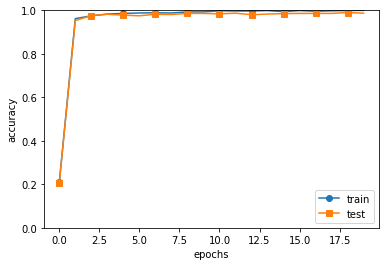

In [8]:
max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

In [ ]:
# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

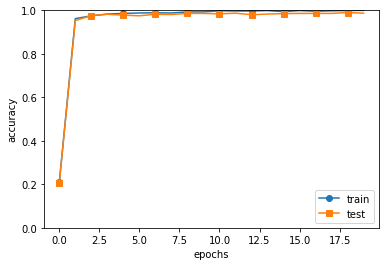

In [9]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# visualize_filter.py

In [11]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

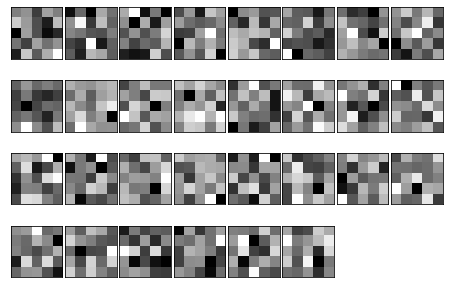

In [12]:
network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

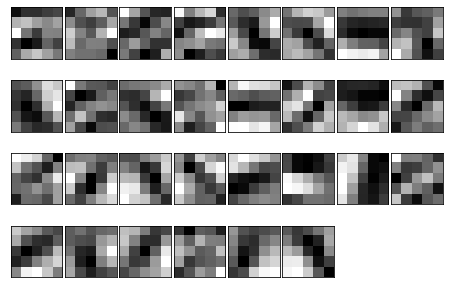

In [13]:
# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

# gradient_check.py

In [14]:
# coding: utf-8
import numpy as np
#from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 2.3920474403782107e-06
b1 7.367634547064133e-06
W2 6.017621803661483e-11
b2 5.835550886338757e-09
W3 2.602480436929538e-10
b3 1.7991343141815497e-07


# apply_filter.py 

In [16]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

In [17]:
def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')

In [18]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 학습된 가중치
network.load_params("params.pkl")

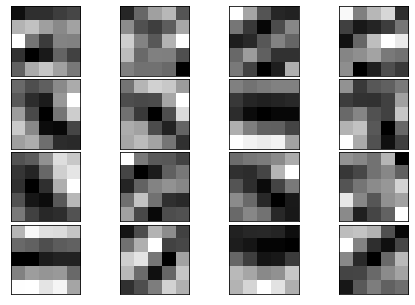

In [19]:
filter_show(network.params['W1'], 16)

In [24]:
#img = imread('./dataset/lena_gray.png')
img = imread('./dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

ValueError: too many values to unpack (expected 4)

<Figure size 432x288 with 0 Axes>